# Chapter 6 Exercises. The Haunted DAG & The Causal Terror.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

alt.renderers.enable("mimetype")  # support rendering on github

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

import statreth as sr
from statreth.utils import suppress_subprocess_output

## 6M1

Modify the DAG on page 190 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which variables should you condition on now?

```
 ┌───────A───────┐      
 │               │      
 │               │      
┌▼┐              ▼      
│U├─────►B◄──────C◄───┐ 
└┬┘              │    │ 
 │               │   ┌┴┐
 │               │   │V│
 ▼               ▼   └┬┘
 X ─────────────►Y◄───┘ 
```

We would like to find a direct effect of `X -> Y` which requires closing all "backdoor" paths that cause biased association.

Backdoor paths:
1. `X <- U <- A -> C <- V -> Y` - closed at collider `C`
2. `X <- U <- A -> C -> Y` - open
3. `X <- U -> B <- C <- V -> Y` closed at collider `B`
4. `X <- U -> B <- C -> Y` - closed at collider `B`

Only path #2 is open. To close it we could condition on `A` or `C` since `U` and `V` are unobserved. Conditioning on `C` would open path # 1 so we can only condition on `A`

## 6H1

Use the Waffle House data, `data(WaffleDivorce)`, to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

Consider DAG from page 191:

```
S ──────────────► W
│ ──────┐         │
│       ▼         │
│ ┌────►M         │
│ │     │         │
▼ │     └───────► ▼
A ──────────────► D
```

To estimate total causal effect of `W` on `D` we need to close all backdoor paths that connect `W` to `D`:

1. `W <- S -> A -> D`
2. `W <- S -> M -> D`
3. `W <- S -> A -> M -> D`

Since `S` is shared among all 3 paths we can condition on `S` to close all of them: `D = f(W, S)`

In [3]:
waffle_df = pd.read_csv("../data/WaffleDivorce.csv", delimiter=";")
waffle_df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
# since `South` is a binary variable we can stratify by it.
data = {"n": waffle_df.shape[0]}

for name in ["WaffleHouses", "Divorce"]:
    d = waffle_df[name].to_numpy()
    d = (d - d.mean()) / d.std()  # z-score
    data[name] = d

data["South"] = waffle_df["South"].to_numpy() + 1

In [5]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

import stan

from statreth.utils import suppress_subprocess_output

In [6]:
# build model: Divorce = f(WaffleHouses, South)
code = """
data {
  int<lower=0> n;
  vector[n] WaffleHouses;
  vector[n] Divorce;
  array[n] int South;
}
parameters {
  vector[2] alpha;
  vector[2] betaW;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 0.2);
  betaW ~ normal(0, 0.5);
  sigma ~ exponential(1);

  // likelihood
  for (i in 1:n) {
      real mu = alpha[South[i]] + betaW[South[i]] * WaffleHouses[i];
      Divorce[i] ~ normal(mu, sigma);
  }  
}
"""

In [7]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)

In [8]:
%%capture
fit = model.sample(num_chains=4, num_samples=1000)

In [9]:
fit_df = fit.to_frame()[["alpha.1", "alpha.2", "betaW.1", "betaW.2", "sigma"]]
fit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,-0.043218,0.157898,-0.638386,-0.154320,-0.043923,0.063959,0.539787
alpha.2,4000.0,0.158292,0.173743,-0.537430,0.039926,0.155661,0.274496,0.813496
betaW.1,4000.0,0.327496,0.362218,-1.266717,0.082062,0.328147,0.569957,1.632568
betaW.2,4000.0,0.122891,0.153071,-0.458077,0.019124,0.121111,0.225561,0.688145
sigma,4000.0,0.981612,0.101794,0.719736,0.910364,0.973454,1.042198,1.408196


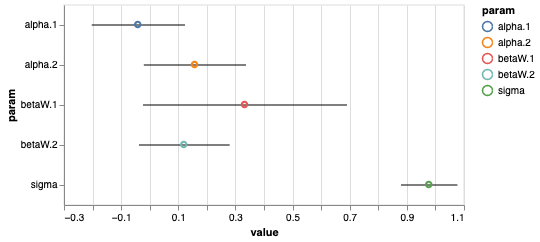

In [10]:
df = fit_df[:1000]
df = df.melt(var_name="param")

error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=False)
    .encode(x=alt.X("value", aggregate="mean"), y="param", color="param")
)

(error_bars + points).properties(width=400, height=200)

In [11]:
# It seems using `South` as a quantative variable would produce "better"
# results since `South` as index variable splits data and makes the
# final results more noisy.

In [12]:
# there is too little data
waffle_df["South"].value_counts()

South
0    36
1    14
Name: count, dtype: int64

<Axes: xlabel='WaffleHouses', ylabel='Divorce'>

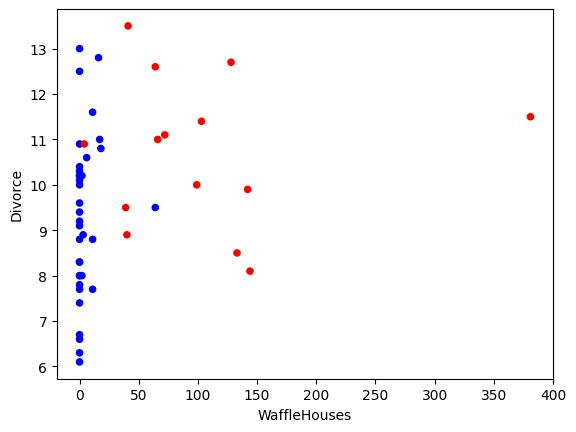

In [13]:
waffle_df["Color"] = waffle_df["South"].map(lambda s: ["blue", "red"][s])
waffle_df.plot.scatter(x="WaffleHouses", y="Divorce", c="Color")

## 6H2

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data.

Using [Daggity](https://www.dagitty.net/dags.html#):

```
dag {
bb="-2.727,-2.165,3.471,1.687"
A [pos="-2.079,0.456"]
D [outcome,pos="1.694,0.447"]
M [pos="-0.657,-0.253"]
S [pos="-2.072,-1.122"]
W [exposure,pos="1.713,-1.160"]
A -> D
A -> M
M -> D
S -> A
S -> M
S -> W
W -> D
}
```

we get the following testable conditions:
```
A ⊥ W | S
D ⊥ S | A, M, W
M ⊥ W | S
```

In [14]:
# Test the first implication: A ⊥ W | S
# Use `South` as quantative variable

data = {"n": waffle_df.shape[0]}

for name in ["MedianAgeMarriage", "WaffleHouses", "South"]:
    d = waffle_df[name].to_numpy()
    d = (d - d.mean()) / d.std()  # z-score
    data[name] = d

In [15]:
# build model: WaffleHouses = f(MedianAgeMarriage, South)
code = """
data {
  int<lower=0> n;
  vector[n] MedianAgeMarriage;
  vector[n] South;
  vector[n] WaffleHouses;
}
parameters {
  real alpha;
  real betaA;
  real betaS;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 0.2);
  betaA ~ normal(0, 0.5);
  betaS ~ normal(0, 0.5);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaA * MedianAgeMarriage + betaS * South;
  WaffleHouses ~ normal(mu, sigma);
}
"""

In [16]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)

In [17]:
%%capture
fit = model.sample(num_chains=4, num_samples=1000)

In [18]:
fit_df = fit.to_frame()[["alpha", "betaA", "betaS", "sigma"]]
fit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,-0.001028,0.095967,-0.419320,-0.064686,-0.000803,0.062753,0.331379
betaA,4000.0,0.043852,0.111450,-0.389943,-0.030213,0.046528,0.118939,0.384540
betaS,4000.0,0.663620,0.109656,0.292182,0.589965,0.662117,0.737804,1.101519
sigma,4000.0,0.762766,0.081056,0.522138,0.704427,0.756223,0.811939,1.108495


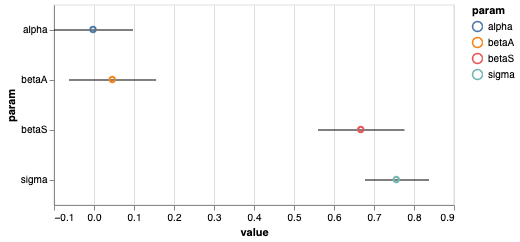

In [19]:
df = fit_df[:1000]
df = df.melt(var_name="param")

error_bars = alt.Chart(df).mark_errorbar(extent="stdev").encode(x="value", y="param")

points = (
    alt.Chart(df)
    .mark_point(filled=False)
    .encode(x=alt.X("value", aggregate="mean"), y="param", color="param")
)

(error_bars + points).properties(width=400, height=200)

<Axes: xlabel='MedianAgeMarriage', ylabel='WaffleHouses'>

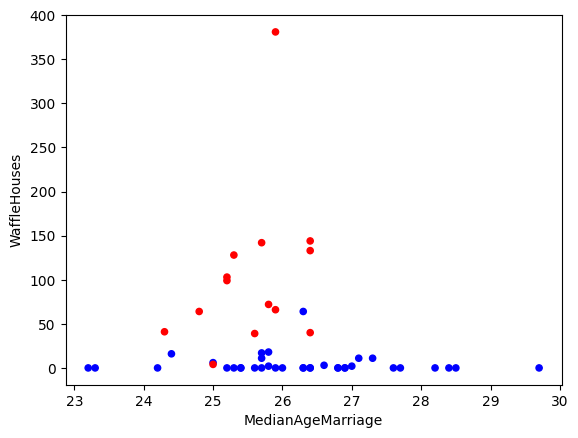

In [20]:
waffle_df["Color"] = waffle_df["South"].map(lambda s: ["blue", "red"][s])
waffle_df.plot.scatter(x="MedianAgeMarriage", y="WaffleHouses", c="Color")